# Description 


**Author**: Felipe Matheus <br>
**Start Date**: 07/06/2022 <br>

# Index

1. Index
1. Setup
1. Load data & models
1. Plotting

# Setup

Libs

In [1]:
import os
import re
import sys
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

Modules

In [135]:
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.processing.Processing import Processing
from src.visualization.Plots import Plots
from src.modeling.Seed import Seed
from src.DataLoader import DataLoader
from src.feature_engineering.FeatureEngineering import FeatureEngineering
from config.Variables import Variables
from src.utils import read_files, read_file

feng = FeatureEngineering()
varv = Variables()
plot = Plots()
proc = Processing()
load_raw = DataLoader(varv.RAW_DATA_PATH)
load_struct =  DataLoader(varv.STRUCTURED_DATA_PATH)
load_models = DataLoader(varv.MODELS_PATH_WORKING)
load_data_plots = DataLoader("../../data/plots/")
seed = Seed(81)

# Load Data

In [136]:
simples = np.load("../../data/plots/Felipe_single_energy_Ba.npy")
dic_prob = np.load("../../data/plots/Felipe_result_CNN_ID_Ba.npy",allow_pickle = True)[0]
tab_proportions = np.load("../../data/plots/Felipe_result_CNN_prop_Ba.npy",allow_pickle = True)

# jeff_values = np.load(f"{varv.STRUCTURED_DATA_PATH}spec_train_2_6sources.npy")
# jeff_labels = np.load(f"{varv.STRUCTURED_DATA_PATH}Yprop_train_2_6sources.npy")

jeff_values_clean = np.load(f"{varv.STRUCTURED_DATA_PATH}Spec_train_2_6sources_no_decalibration_no_bdf.npy")
jeff_labels_clean = np.load(f"{varv.STRUCTURED_DATA_PATH}Yprop_train_2_6sources_no_decalibration_no_bdf.npy")

attenuation = np.load(f"{varv.STRUCTURED_DATA_PATH}att_proba.npy")
attenuation_labels = np.load(f"{varv.STRUCTURED_DATA_PATH}labels_att.npy")

In [137]:
models = {model: tf.keras.models.load_model(model_path)
          for model_path, model in zip(load_models.files_path, load_models.files)}
keys = load_models.files

In [56]:
def prepare_box(ax, proportions, box_positions):
    elements = ["$^{241}$Am","$^{133}$Ba","$^{57}$Co","$^{137}$Cs","$^{152}$Eu","$^{22}$Na","$^{27}$Al"]
    s = "Elements proportions: "
    for i in range(len(proportions)-1):
        s += "\n"+elements[i]+": "+str(np.round(proportions[i]*100,1)) + " %"

    if proportions[-1] != 0: 
        s += "\nAttenuation: "
        s += "\n"+elements[-1]+": "+str(proportions[-1]) + "cm"

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(box_positions[0], box_positions[1], s, transform=ax.transAxes, fontsize=11.5,
            verticalalignment='top', bbox=props)

# Pb preparation

In [4]:
Source_list = ["Am241", "Ba133", "Co57", "Cs137", "Eu152", "Na22",
               "Ga67", "I131", "Ir192", "U235D", "Tc99m", "Tl201",
               "Ra226D", "Co60"]
a2 = 100  # Nombre d'itérations pour appliquer réseaux bayésiens

seuilphot = 50  # Seuil en photons à partir duquel on lance le réseau

# Seuil à partir duquel on considère que la source est présente (pour le 1er quartile)
thpresence = 0.8

# Seuil sur lequel on considère la source incertaine (pour le 3ème quartile)
thuncer = 0.8


C:\Users\ff268477\AppData\Local\Temp\ipykernel_10424\3196429162.py:144: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
C:\Users\ff268477\AppData\Local\Temp\ipykernel_10424\3196429162.py:155: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


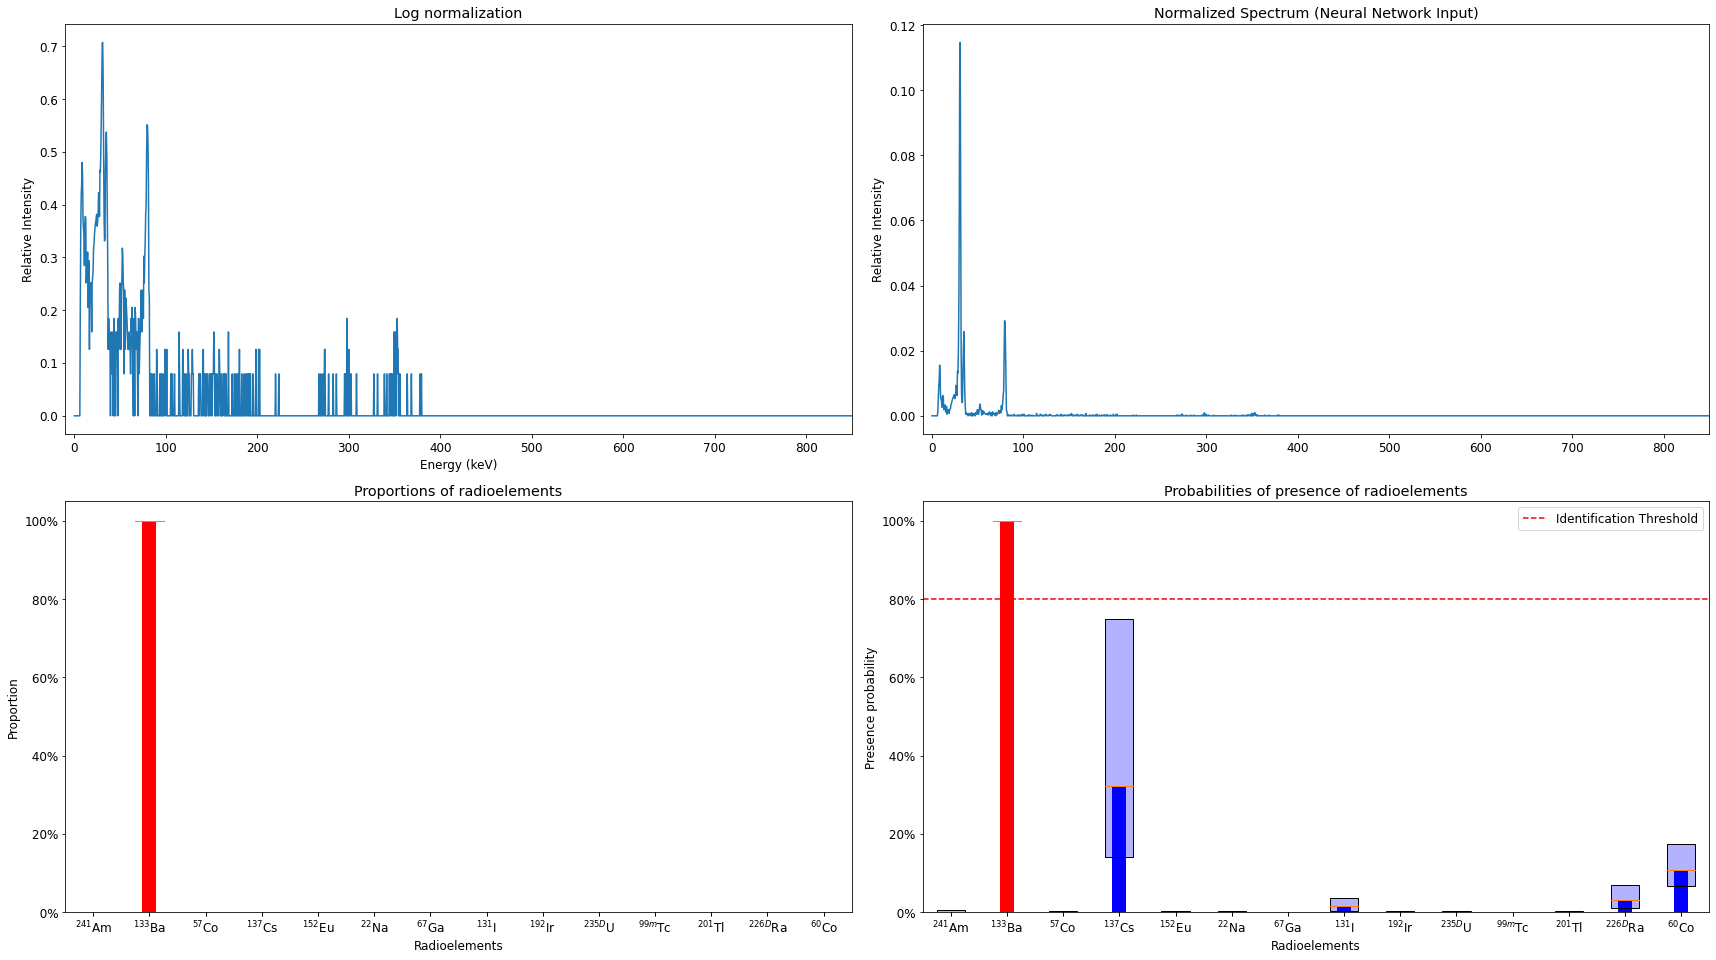

In [5]:
Nsources = np.size(Source_list)

Sourceslabel = np.array(Source_list,dtype = "<U12")

for i in range(Nsources):
    
    a = re.split("(\d+)",Source_list[i])
    
    Sourceslabel[i] = r"$^{"+a[1]+a[2]+"}$"+a[0]
    

t, b = np.histogram(simples, bins = 2000, range =(0,1000))

t[0] = 0

# t[np.where((b > 230)*(b < 250))] = 0

Nphot = np.sum(t)

s = t*1.

s = s + 1

s = s/np.sum(s)

s = np.log(s)

s = s/-np.min(s) + 1

s_prop = t/np.sum(t)

    
s = np.expand_dims(s,axis = 0)
s = np.expand_dims(s,axis = 2)

s = np.repeat(s,a2,axis = 0)
s_prop = t/np.sum(t)

s_prop = np.expand_dims(s_prop,axis = 0)
s_prop = np.expand_dims(s_prop,axis = 2)
s_prop = np.repeat(s_prop,a2,axis = 0)
    

dic_proportions = {}

list_prob = []

list_proportions = []

medians = np.zeros((Nsources))

medians_prop = np.zeros((Nsources))

q1 = np.zeros((Nsources))

q3 = np.zeros((Nsources))




for i in range(Nsources):
    
    
    
    list_prob.append(dic_prob[Source_list[i]])
    
    medians[i] = np.median(dic_prob[Source_list[i]])
    
    q1[i] = np.percentile(dic_prob[Source_list[i]],25)
    
    q3[i] = np.percentile(dic_prob[Source_list[i]],75)
    

        

#    tab_proportions = tab_proportions/np.sum(tab_proportions,axis = 0)

if np.sum(q3 > thuncer) == 1:
    tab_proportions = tab_proportions/np.sum(tab_proportions,axis = 0)
    
for i in range(Nsources):
    
    dic_proportions[Source_list[i]] = tab_proportions[i]
    
    medians_prop[i] = np.median(dic_proportions[Source_list[i]])
        
    list_proportions.append(dic_proportions[Source_list[i]])



p = np.zeros((6,Nsources))

medianlist = medians*1.
q1list = q1*1.
q3list = q3*1.



p[0] = medianlist
p[1] = q1list
p[2] = q3list

proptot = tab_proportions*1.
        
medianproplist = np.median(proptot,axis = 1)
q1proplist = np.percentile(proptot,25,axis = 1)
q3proplist = np.percentile(proptot,75,axis = 1)
    
p[3] = medianproplist
p[4] = q1proplist
p[5] = q3proplist                

fig = plt.figure(figsize = (16*1.5,9*1.5))        
fig.clf()

plt.rcParams.update({"font.size":12})

ax1 = fig.add_subplot(2,2,1)

ax1.plot(np.arange(2000)/2,s[0,:,0])
ax1.set_xlabel("Energy (keV)")
ax1.set_ylabel("Relative Intensity")
ax1.set_title("Log normalization")
ax1.set_xlim([-10,850])

ax4 = fig.add_subplot(2,2,2)

ax4.plot(np.arange(2000)/2,s_prop[0,:,0])
ax4.set_ylabel("Relative Intensity")
ax4.set_title("Log normalization")
ax4.set_title("Normalized Spectrum (Neural Network Input)")
ax4.set_xlim([-10,850])


ax2 = fig.add_subplot(2,2,4)

ax2.set_ylabel("Presence probability")
ax2.set_xlabel("Radioelements")
ax2.set_ylim([0,1.05])

ax2.set_xticks(np.arange(Nsources))
ax2.set_xticklabels(Sourceslabel)
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])

ax3 = fig.add_subplot(2,2,3)

ax3.set_ylabel("Proportion")
ax3.set_xlabel("Radioelements")
ax3.set_ylim([0,1.05])

ax3.set_xticks(np.arange(Nsources))
ax3.set_xticklabels(Sourceslabel)
vals = ax3.get_yticks()
ax3.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
                
xcol = np.arange(Nsources)
                
width2 = 0.25

a21 = ax2.bar(xcol, xcol*0., width=width2,color = 'blue', align = "center")
a22 = ax2.bar(xcol, xcol*0., width=width2,color = 'orange', align = "center")
a23 = ax2.bar(xcol, xcol*0., width=width2,color = 'red', align = "center")

a31 = ax3.bar(xcol, xcol*0., width=width2,color = 'red', align = "center")
a32 = ax3.bar(xcol, xcol*0., width=width2,color = 'orange', align = "center")

ax2.axhline(thuncer,color = "red", linestyle = "--",label = "Identification Threshold")

ax2.legend()
                
bplot = ax2.boxplot(list_prob,vert = True, sym = "", patch_artist = True,\
                   whis = 0, labels = Sourceslabel,\
                   positions = list(np.arange(Nsources)))

bplot2 = ax3.boxplot(list_proportions,vert = True, sym = "", patch_artist = True,\
                   labels = Sourceslabel,\
                   positions = list(np.arange(Nsources)))


colors = ["b" for i in range(Nsources)]

mask1 = medianlist < thpresence
mask2 = (q1list < thuncer)*(q3list > thuncer)
mask3 = medianlist >= thpresence

for i in range(Nsources):
    

    if mask2[i]:
        colors[i] = "orange"
    elif medianlist[i] > thpresence:
        colors[i] = "r"
    else:
        colors[i] = "b"
        

for patch,color in zip(bplot["boxes"],colors):
    
    patch.set_facecolor(color)
    red,g,b,a = patch.get_facecolor()
    patch.set_facecolor((red,g,b,0.3))
    
for patch,color in zip(bplot2["boxes"],colors):
    
    patch.set_facecolor(color)
    red,g,b,a = patch.get_facecolor()
    patch.set_facecolor((red,g,b,0.3))

for i in range(Nsources):

    if mask1[i]:
        a21.patches[i].set_height(medianlist[i])
        a22.patches[i].set_height(0)
        a23.patches[i].set_height(0)
    if mask3[i]:
        a21.patches[i].set_height(0)
        a22.patches[i].set_height(0)
        a23.patches[i].set_height(medianlist[i])
    if mask2[i]:
        a21.patches[i].set_height(0)
        a22.patches[i].set_height(medianlist[i])
        a23.patches[i].set_height(0)
        
    if mask3[i]:
        a31.patches[i].set_height(medians_prop[i])
        a32.patches[i].set_height(0)
        
    if mask2[i]:
        a31.patches[i].set_height(0)
        a32.patches[i].set_height(medians_prop[i])
    


ax2.set_title("Probabilities of presence of radioelements")

ax3.set_title("Proportions of radioelements")

plt.tight_layout()

C:\Users\ff268477\AppData\Local\Temp\ipykernel_10424\3196429162.py:144: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
C:\Users\ff268477\AppData\Local\Temp\ipykernel_10424\3196429162.py:155: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


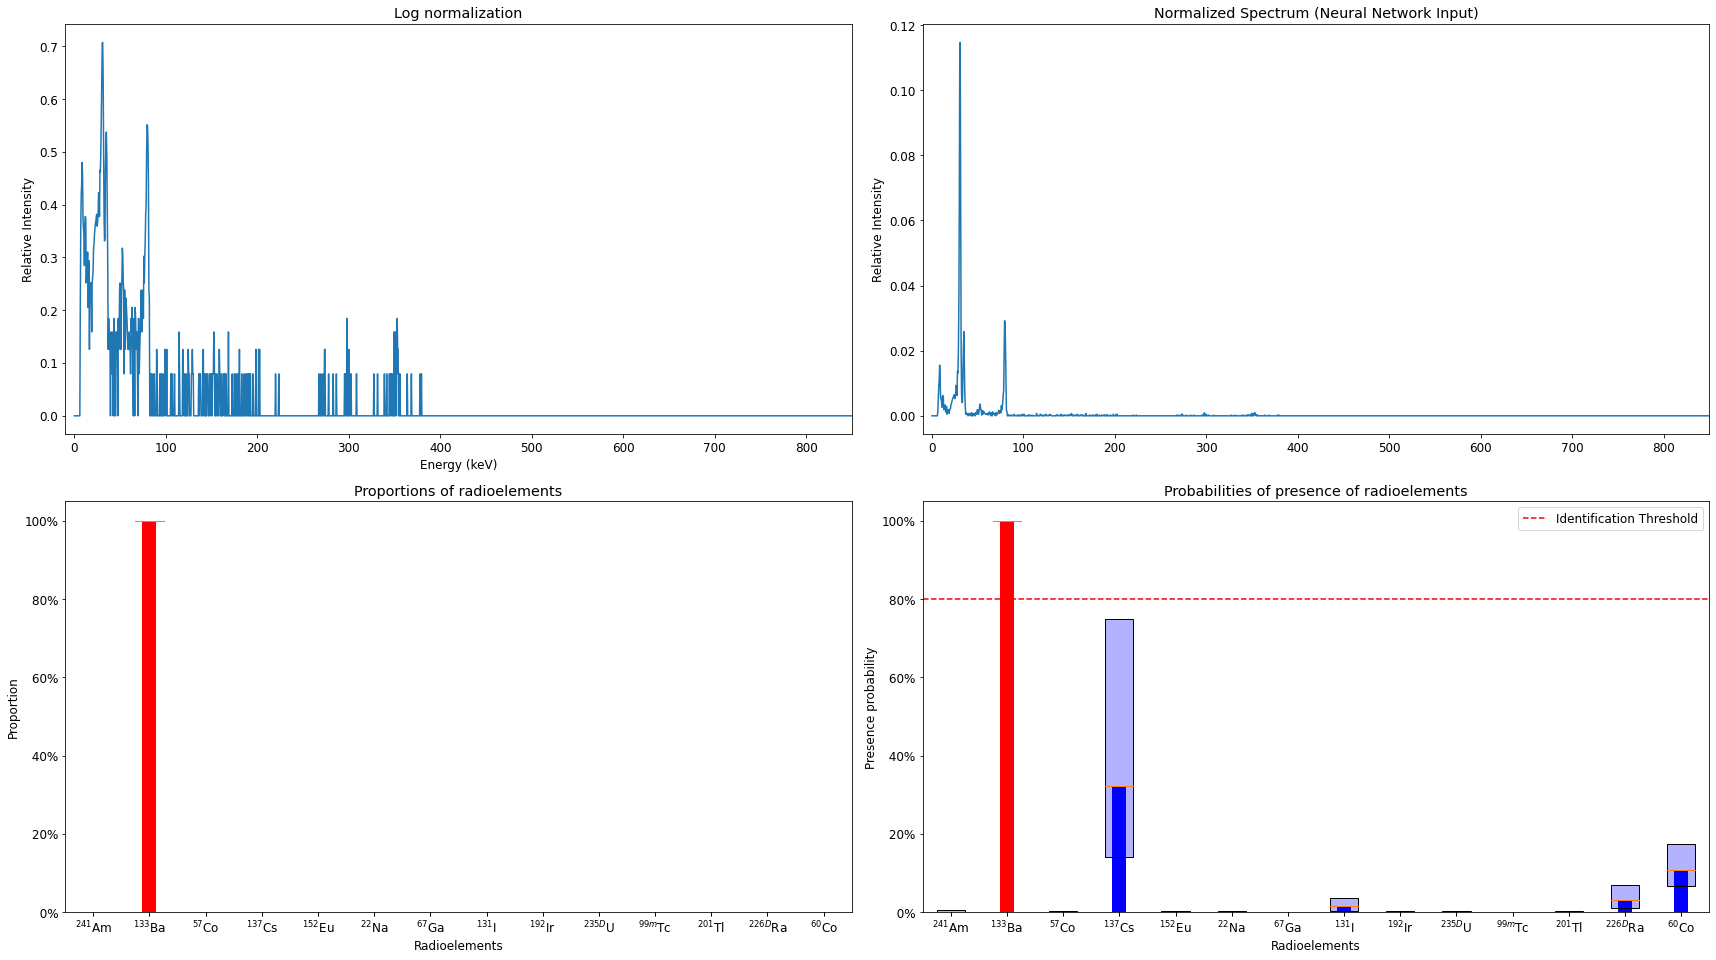

In [6]:
Nsources = np.size(Source_list)

Sourceslabel = np.array(Source_list,dtype = "<U12")

for i in range(Nsources):
    
    a = re.split("(\d+)",Source_list[i])
    
    Sourceslabel[i] = r"$^{"+a[1]+a[2]+"}$"+a[0]
    

t, b = np.histogram(simples, bins = 2000, range =(0,1000))

t[0] = 0

# t[np.where((b > 230)*(b < 250))] = 0

Nphot = np.sum(t)

s = t*1.

s = s + 1

s = s/np.sum(s)

s = np.log(s)

s = s/-np.min(s) + 1

s_prop = t/np.sum(t)

    
s = np.expand_dims(s,axis = 0)
s = np.expand_dims(s,axis = 2)

s = np.repeat(s,a2,axis = 0)
s_prop = t/np.sum(t)

s_prop = np.expand_dims(s_prop,axis = 0)
s_prop = np.expand_dims(s_prop,axis = 2)
s_prop = np.repeat(s_prop,a2,axis = 0)
    

dic_proportions = {}

list_prob = []

list_proportions = []

medians = np.zeros((Nsources))

medians_prop = np.zeros((Nsources))

q1 = np.zeros((Nsources))

q3 = np.zeros((Nsources))




for i in range(Nsources):
    
    
    
    list_prob.append(dic_prob[Source_list[i]])
    
    medians[i] = np.median(dic_prob[Source_list[i]])
    
    q1[i] = np.percentile(dic_prob[Source_list[i]],25)
    
    q3[i] = np.percentile(dic_prob[Source_list[i]],75)
    

        

#    tab_proportions = tab_proportions/np.sum(tab_proportions,axis = 0)

if np.sum(q3 > thuncer) == 1:
    tab_proportions = tab_proportions/np.sum(tab_proportions,axis = 0)
    
for i in range(Nsources):
    
    dic_proportions[Source_list[i]] = tab_proportions[i]
    
    medians_prop[i] = np.median(dic_proportions[Source_list[i]])
        
    list_proportions.append(dic_proportions[Source_list[i]])



p = np.zeros((6,Nsources))

medianlist = medians*1.
q1list = q1*1.
q3list = q3*1.



p[0] = medianlist
p[1] = q1list
p[2] = q3list

proptot = tab_proportions*1.
        
medianproplist = np.median(proptot,axis = 1)
q1proplist = np.percentile(proptot,25,axis = 1)
q3proplist = np.percentile(proptot,75,axis = 1)
    
p[3] = medianproplist
p[4] = q1proplist
p[5] = q3proplist                

fig = plt.figure(figsize = (16*1.5,9*1.5))        
fig.clf()

plt.rcParams.update({"font.size":12})

ax1 = fig.add_subplot(2,2,1)

ax1.plot(np.arange(2000)/2,s[0,:,0])
ax1.set_xlabel("Energy (keV)")
ax1.set_ylabel("Relative Intensity")
ax1.set_title("Log normalization")
ax1.set_xlim([-10,850])

ax4 = fig.add_subplot(2,2,2)

ax4.plot(np.arange(2000)/2,s_prop[0,:,0])
ax4.set_ylabel("Relative Intensity")
ax4.set_title("Log normalization")
ax4.set_title("Normalized Spectrum (Neural Network Input)")
ax4.set_xlim([-10,850])


ax2 = fig.add_subplot(2,2,4)

ax2.set_ylabel("Presence probability")
ax2.set_xlabel("Radioelements")
ax2.set_ylim([0,1.05])

ax2.set_xticks(np.arange(Nsources))
ax2.set_xticklabels(Sourceslabel)
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])

ax3 = fig.add_subplot(2,2,3)

ax3.set_ylabel("Proportion")
ax3.set_xlabel("Radioelements")
ax3.set_ylim([0,1.05])

ax3.set_xticks(np.arange(Nsources))
ax3.set_xticklabels(Sourceslabel)
vals = ax3.get_yticks()
ax3.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
                
xcol = np.arange(Nsources)
                
width2 = 0.25

a21 = ax2.bar(xcol, xcol*0., width=width2,color = 'blue', align = "center")
a22 = ax2.bar(xcol, xcol*0., width=width2,color = 'orange', align = "center")
a23 = ax2.bar(xcol, xcol*0., width=width2,color = 'red', align = "center")

a31 = ax3.bar(xcol, xcol*0., width=width2,color = 'red', align = "center")
a32 = ax3.bar(xcol, xcol*0., width=width2,color = 'orange', align = "center")

ax2.axhline(thuncer,color = "red", linestyle = "--",label = "Identification Threshold")

ax2.legend()
                
bplot = ax2.boxplot(list_prob,vert = True, sym = "", patch_artist = True,\
                   whis = 0, labels = Sourceslabel,\
                   positions = list(np.arange(Nsources)))

bplot2 = ax3.boxplot(list_proportions,vert = True, sym = "", patch_artist = True,\
                   labels = Sourceslabel,\
                   positions = list(np.arange(Nsources)))


colors = ["b" for i in range(Nsources)]

mask1 = medianlist < thpresence
mask2 = (q1list < thuncer)*(q3list > thuncer)
mask3 = medianlist >= thpresence

for i in range(Nsources):
    

    if mask2[i]:
        colors[i] = "orange"
    elif medianlist[i] > thpresence:
        colors[i] = "r"
    else:
        colors[i] = "b"
        

for patch,color in zip(bplot["boxes"],colors):
    
    patch.set_facecolor(color)
    red,g,b,a = patch.get_facecolor()
    patch.set_facecolor((red,g,b,0.3))
    
for patch,color in zip(bplot2["boxes"],colors):
    
    patch.set_facecolor(color)
    red,g,b,a = patch.get_facecolor()
    patch.set_facecolor((red,g,b,0.3))

for i in range(Nsources):

    if mask1[i]:
        a21.patches[i].set_height(medianlist[i])
        a22.patches[i].set_height(0)
        a23.patches[i].set_height(0)
    if mask3[i]:
        a21.patches[i].set_height(0)
        a22.patches[i].set_height(0)
        a23.patches[i].set_height(medianlist[i])
    if mask2[i]:
        a21.patches[i].set_height(0)
        a22.patches[i].set_height(medianlist[i])
        a23.patches[i].set_height(0)
        
    if mask3[i]:
        a31.patches[i].set_height(medians_prop[i])
        a32.patches[i].set_height(0)
        
    if mask2[i]:
        a31.patches[i].set_height(0)
        a32.patches[i].set_height(medians_prop[i])
    


ax2.set_title("Probabilities of presence of radioelements")

ax3.set_title("Proportions of radioelements")

plt.tight_layout()

## 2x2 sem chumbo 

C:\Users\ff268477\AppData\Local\Temp\ipykernel_10424\2395672190.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


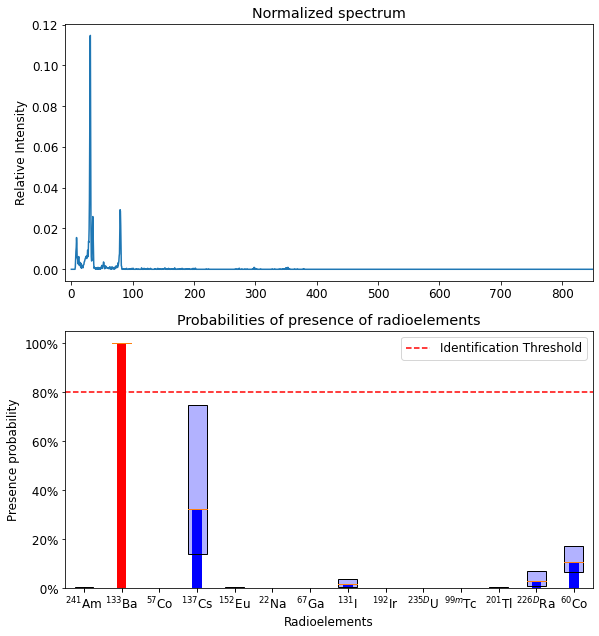

In [7]:
simples = np.load("../../data/plots/Felipe_single_energy_Ba.npy")
dic_prob = np.load("../../data/plots/Felipe_result_CNN_ID_Ba.npy",allow_pickle = True)[0]
tab_proportions = np.load("../../data/plots/Felipe_result_CNN_prop_Ba.npy",allow_pickle = True)

Nsources = np.size(Source_list)

Sourceslabel = np.array(Source_list,dtype = "<U12")

for i in range(Nsources):
    
    a = re.split("(\d+)",Source_list[i])
    
    Sourceslabel[i] = r"$^{"+a[1]+a[2]+"}$"+a[0]
    

t, b = np.histogram(simples, bins = 2000, range =(0,1000))

t[0] = 0

# t[np.where((b > 230)*(b < 250))] = 0

Nphot = np.sum(t)

s = t*1.

s = s + 1

s = s/np.sum(s)

s = np.log(s)

s = s/-np.min(s) + 1

s_prop = t/np.sum(t)

    
s = np.expand_dims(s,axis = 0)
s = np.expand_dims(s,axis = 2)

s = np.repeat(s,a2,axis = 0)
s_prop = t/np.sum(t)

s_prop = np.expand_dims(s_prop,axis = 0)
s_prop = np.expand_dims(s_prop,axis = 2)
s_prop = np.repeat(s_prop,a2,axis = 0)
    

dic_proportions = {}

list_prob = []

list_proportions = []

medians = np.zeros((Nsources))

medians_prop = np.zeros((Nsources))

q1 = np.zeros((Nsources))

q3 = np.zeros((Nsources))




for i in range(Nsources):
    
    
    
    list_prob.append(dic_prob[Source_list[i]])
    
    medians[i] = np.median(dic_prob[Source_list[i]])
    
    q1[i] = np.percentile(dic_prob[Source_list[i]],25)
    
    q3[i] = np.percentile(dic_prob[Source_list[i]],75)
    

        

#    tab_proportions = tab_proportions/np.sum(tab_proportions,axis = 0)

if np.sum(q3 > thuncer) == 1:
    tab_proportions = tab_proportions/np.sum(tab_proportions,axis = 0)
    
for i in range(Nsources):
    
    dic_proportions[Source_list[i]] = tab_proportions[i]
    
    medians_prop[i] = np.median(dic_proportions[Source_list[i]])
        
    list_proportions.append(dic_proportions[Source_list[i]])



p = np.zeros((6,Nsources))

medianlist = medians*1.
q1list = q1*1.
q3list = q3*1.



p[0] = medianlist
p[1] = q1list
p[2] = q3list

proptot = tab_proportions*1.
        
medianproplist = np.median(proptot,axis = 1)
q1proplist = np.percentile(proptot,25,axis = 1)
q3proplist = np.percentile(proptot,75,axis = 1)
    
p[3] = medianproplist
p[4] = q1proplist
p[5] = q3proplist                

fig = plt.figure(figsize = (16,9))        
fig.clf()

plt.rcParams.update({"font.size":12})

ax4 = fig.add_subplot(2,2,2)

ax4.plot(np.arange(2000)/2,s_prop[0,:,0])
ax4.set_ylabel("Relative Intensity")
ax4.set_title("Log normalization")
ax4.set_xlim([-10,850])


ax2 = fig.add_subplot(2,2,4)

ax2.set_ylabel("Presence probability")
ax2.set_xlabel("Radioelements")
ax2.set_ylim([0,1.05])

ax2.set_xticks(np.arange(Nsources))
ax2.set_xticklabels(Sourceslabel)
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
                
xcol = np.arange(Nsources)
                
width2 = 0.25

a21 = ax2.bar(xcol, xcol*0., width=width2,color = 'blue', align = "center")
a22 = ax2.bar(xcol, xcol*0., width=width2,color = 'orange', align = "center")
a23 = ax2.bar(xcol, xcol*0., width=width2,color = 'red', align = "center")

ax2.axhline(thuncer,color = "red", linestyle = "--",label = "Identification Threshold")

ax2.legend()
                
bplot = ax2.boxplot(list_prob,vert = True, sym = "", patch_artist = True,\
                   whis = 0, labels = Sourceslabel,\
                   positions = list(np.arange(Nsources)))

colors = ["b" for i in range(Nsources)]

mask1 = medianlist < thpresence
mask2 = (q1list < thuncer)*(q3list > thuncer)
mask3 = medianlist >= thpresence

for i in range(Nsources):
    

    if mask2[i]:
        colors[i] = "orange"
    elif medianlist[i] > thpresence:
        colors[i] = "r"
    else:
        colors[i] = "b"
        

for patch,color in zip(bplot["boxes"],colors):
    
    patch.set_facecolor(color)
    red,g,b,a = patch.get_facecolor()
    patch.set_facecolor((red,g,b,0.3))
    
for patch,color in zip(bplot2["boxes"],colors):
    
    patch.set_facecolor(color)
    red,g,b,a = patch.get_facecolor()
    patch.set_facecolor((red,g,b,0.3))

for i in range(Nsources):

    if mask1[i]:
        a21.patches[i].set_height(medianlist[i])
        a22.patches[i].set_height(0)
        a23.patches[i].set_height(0)
    if mask3[i]:
        a21.patches[i].set_height(0)
        a22.patches[i].set_height(0)
        a23.patches[i].set_height(medianlist[i])
    if mask2[i]:
        a21.patches[i].set_height(0)
        a22.patches[i].set_height(medianlist[i])
        a23.patches[i].set_height(0)
        
    if mask3[i]:
        a31.patches[i].set_height(medians_prop[i])
        a32.patches[i].set_height(0)
        
    if mask2[i]:
        a31.patches[i].set_height(0)
        a32.patches[i].set_height(medians_prop[i])
    

ax4.set_title("Normalized spectrum")#, fontsize=12)

ax2.set_title("Probabilities of presence of radioelements")#, fontsize=12)

plt.tight_layout()
plt.savefig('direct_ba_spec.pdf', bbox_inches='tight')  

## 2 por 2 com chumbo

C:\Users\ff268477\AppData\Local\Temp\ipykernel_10424\3666294070.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


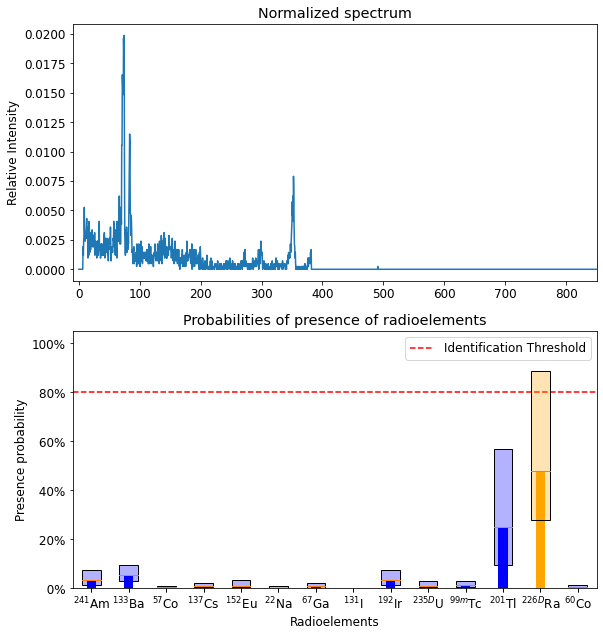

In [8]:
simples = np.load("../../data/plots/Felipe_single_energy_Ba_plomb.npy")
dic_prob = np.load("../../data/plots/Felipe_result_CNN_ID_Ba_plomb.npy",allow_pickle = True)[0]
tab_proportions = np.load("../../data/plots/Felipe_result_CNN_prop_Ba_plomb.npy",allow_pickle = True)

Nsources = np.size(Source_list)

Sourceslabel = np.array(Source_list,dtype = "<U12")

for i in range(Nsources):
    
    a = re.split("(\d+)",Source_list[i])
    
    Sourceslabel[i] = r"$^{"+a[1]+a[2]+"}$"+a[0]
    

t, b = np.histogram(simples, bins = 2000, range =(0,1000))

t[0] = 0

# t[np.where((b > 230)*(b < 250))] = 0

Nphot = np.sum(t)

s = t*1.

s = s + 1

s = s/np.sum(s)

s = np.log(s)

s = s/-np.min(s) + 1

s_prop = t/np.sum(t)

    
s = np.expand_dims(s,axis = 0)
s = np.expand_dims(s,axis = 2)

s = np.repeat(s,a2,axis = 0)
s_prop = t/np.sum(t)

s_prop = np.expand_dims(s_prop,axis = 0)
s_prop = np.expand_dims(s_prop,axis = 2)
s_prop = np.repeat(s_prop,a2,axis = 0)
    

dic_proportions = {}

list_prob = []

list_proportions = []

medians = np.zeros((Nsources))

medians_prop = np.zeros((Nsources))

q1 = np.zeros((Nsources))

q3 = np.zeros((Nsources))




for i in range(Nsources):
    
    
    
    list_prob.append(dic_prob[Source_list[i]])
    
    medians[i] = np.median(dic_prob[Source_list[i]])
    
    q1[i] = np.percentile(dic_prob[Source_list[i]],25)
    
    q3[i] = np.percentile(dic_prob[Source_list[i]],75)
    

        

#    tab_proportions = tab_proportions/np.sum(tab_proportions,axis = 0)

if np.sum(q3 > thuncer) == 1:
    tab_proportions = tab_proportions/np.sum(tab_proportions,axis = 0)
    
for i in range(Nsources):
    
    dic_proportions[Source_list[i]] = tab_proportions[i]
    
    medians_prop[i] = np.median(dic_proportions[Source_list[i]])
        
    list_proportions.append(dic_proportions[Source_list[i]])



p = np.zeros((6,Nsources))

medianlist = medians*1.
q1list = q1*1.
q3list = q3*1.



p[0] = medianlist
p[1] = q1list
p[2] = q3list

proptot = tab_proportions*1.
        
medianproplist = np.median(proptot,axis = 1)
q1proplist = np.percentile(proptot,25,axis = 1)
q3proplist = np.percentile(proptot,75,axis = 1)
    
p[3] = medianproplist
p[4] = q1proplist
p[5] = q3proplist                

fig = plt.figure(figsize = (16,9))        
fig.clf()

plt.rcParams.update({"font.size":12})

ax4 = fig.add_subplot(2,2,2)

ax4.plot(np.arange(2000)/2,s_prop[0,:,0])
ax4.set_ylabel("Relative Intensity")
ax4.set_title("Log normalization")
ax4.set_xlim([-10,850])


ax2 = fig.add_subplot(2,2,4)

ax2.set_ylabel("Presence probability")
ax2.set_xlabel("Radioelements")
ax2.set_ylim([0,1.05])

ax2.set_xticks(np.arange(Nsources))
ax2.set_xticklabels(Sourceslabel)
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
                
xcol = np.arange(Nsources)
                
width2 = 0.25

a21 = ax2.bar(xcol, xcol*0., width=width2,color = 'blue', align = "center")
a22 = ax2.bar(xcol, xcol*0., width=width2,color = 'orange', align = "center")
a23 = ax2.bar(xcol, xcol*0., width=width2,color = 'red', align = "center")

ax2.axhline(thuncer,color = "red", linestyle = "--",label = "Identification Threshold")

ax2.legend()
                
bplot = ax2.boxplot(list_prob,vert = True, sym = "", patch_artist = True,\
                   whis = 0, labels = Sourceslabel,\
                   positions = list(np.arange(Nsources)))

colors = ["b" for i in range(Nsources)]

mask1 = medianlist < thpresence
mask2 = (q1list < thuncer)*(q3list > thuncer)
mask3 = medianlist >= thpresence

for i in range(Nsources):
    

    if mask2[i]:
        colors[i] = "orange"
    elif medianlist[i] > thpresence:
        colors[i] = "r"
    else:
        colors[i] = "b"
        

for patch,color in zip(bplot["boxes"],colors):
    
    patch.set_facecolor(color)
    red,g,b,a = patch.get_facecolor()
    patch.set_facecolor((red,g,b,0.3))
    
for patch,color in zip(bplot2["boxes"],colors):
    
    patch.set_facecolor(color)
    red,g,b,a = patch.get_facecolor()
    patch.set_facecolor((red,g,b,0.3))

for i in range(Nsources):

    if mask1[i]:
        a21.patches[i].set_height(medianlist[i])
        a22.patches[i].set_height(0)
        a23.patches[i].set_height(0)
    if mask3[i]:
        a21.patches[i].set_height(0)
        a22.patches[i].set_height(0)
        a23.patches[i].set_height(medianlist[i])
    if mask2[i]:
        a21.patches[i].set_height(0)
        a22.patches[i].set_height(medianlist[i])
        a23.patches[i].set_height(0)
        
    if mask3[i]:
        a31.patches[i].set_height(medians_prop[i])
        a32.patches[i].set_height(0)
        
    if mask2[i]:
        a31.patches[i].set_height(0)
        a32.patches[i].set_height(medians_prop[i])
    

ax4.set_title("Normalized spectrum")#, fontsize=12)

ax2.set_title("Probabilities of presence of radioelements")#, fontsize=12)

plt.tight_layout()
plt.savefig('ba_behind_pb_spec.pdf', bbox_inches='tight')  

# Results

## Real data

In [9]:
n_photons_mask = np.sum(jeff_values_clean, axis=1) > 9e7
am_mask_clean = jeff_labels_clean[:, 0] == 1
ba_mask_clean = jeff_labels_clean[:, 1] == 1
co_mask_clean = jeff_labels_clean[:, 2] == 1
cs_mask_clean = jeff_labels_clean[:, 3] == 1
eu_mask_clean = jeff_labels_clean[:, 4] == 1
na_mask_clean = jeff_labels_clean[:, 5] == 1

am_ex_clean = jeff_values_clean[n_photons_mask*am_mask_clean][0]
ba_ex_clean = jeff_values_clean[n_photons_mask*ba_mask_clean][0]
co_ex_clean = jeff_values_clean[n_photons_mask*co_mask_clean][0]
cs_ex_clean = jeff_values_clean[n_photons_mask*cs_mask_clean][0]
eu_ex_clean = jeff_values_clean[n_photons_mask*eu_mask_clean][0]
na_ex_clean = jeff_values_clean[n_photons_mask*na_mask_clean][0]


In [10]:
examples = np.array([am_ex_clean,
                     ba_ex_clean,
                     co_ex_clean,
                     cs_ex_clean,
                     eu_ex_clean,
                     na_ex_clean])
examples_norm = examples/np.sum(examples, axis=1, keepdims=True)

In [11]:
mixed_ex = \
    examples_norm[0]*0.099 + \
    examples_norm[1]*0.229 + \
    examples_norm[2]*0.128 + \
    examples_norm[3]*0.083 + \
    examples_norm[4]*0.224 + \
    examples_norm[5]*0.237


In [13]:
att_ex = examples_norm[3]*0.3 + examples_norm[4]*0.7
att_ex = att_ex/np.max(att_ex, keepdims=True)
att_ex = np.multiply(att_ex, attenuation[1])
att_ex = att_ex/np.sum(att_ex, keepdims=True)
assert math.isclose(sum(att_ex),  1)

## Supervised Jeff

In [40]:
jeff_am_clean = np.load("../../data/plots/Jeff_Am_no_attenuation_MC_nobdf_nodecalibration.npy")
jeff_mix_clean = np.load("../../data/plots/Jeff_Arbitrary_mix_no_attenuation_nobdf_nodecalibration.npy")
jeff_att_clean = np.load("../../data/plots/Jeff_Cs_Eu_aluminium_MC_nobdf_nodecalibration.npy")

## GAN

In [134]:
list(models.keys())

['att_generator_epoch50.hdf5',
 'generator_epoch130_no_noise_only_jeff.hdf5',
 'generator_epoch20_no_noise_full_data.hdf5',
 'last_architecture_generator_epoch20.hdf5',
 'last_architecture_generator_epoch42.hdf5',
 'last_architecture_generator_epoch9.hdf5',
 'log_generator_epoch10.hdf5']

Americium

In [17]:
# 1.6331005 ,  0.9749512 , -0.22803071,  1.2477231 ,
#           1.0646975 , -0.60154355,  0.32371828, -1.5379577 ,
#          -1.7610457 ,  1.5341674 , -1.3751171 ,  0.48548207,
#          -0.8222661 , -0.8732501 ,  0.14496984,  0.44431952,
#           0.59366935, -0.23954348, -0.6806813 ,  1.0000834 ,
#          -0.8472298 ,  0.4774619 , -0.51623815,  0.16302569,
#           0.23841475, -0.25778008,  1.3364    ,  1.7036128 ,
#           1.3125467 ,  0.9959086 ,  1.3524239 , -1.0241897 ,
#          -0.44851208, -1.2356387 ,  0.05968663,  0.33848178,
#           1.0053632 , -1.9496971 ,  0.8695785 , -1.8932005 ,
#          -0.96345496, -0.16942407, -0.6856296 ,  1.5102239 ,
#          -1.13866   ,  1.3400835 , -0.3364374 ,  0.5412589 ,
#           0.32529876, -0.08899067,  0.5208244 , -0.9869728 ,
#          -1.0951736 , -1.6684982 , -1.6034853 , -1.1685221 ,
#          -1.84993   , -0.17291123, -1.1771781 , -1.2219993 ,
#          -1.2048197 ,  1.7286657 , -0.30235422,  0.08672906,

In [68]:
s = seed.get_concat_noise_with_label(
    labels=np.array(
        [[1, 0, 0, 0., 0, 0,0]]
    ),
    std=0.3
)
am_gan = models["last_architecture_generator_epoch42.hdf5"](s)[0,:, 0].numpy()
am_gan_norm = am_gan/np.sum(am_gan)


Random mix

In [69]:
s = seed.get_concat_noise_with_label(
    labels=np.array(
        [[0.099, 0.229, 0.128, 0.083, 0.224, 0.237, 0]]
    ),
    std=1
)
mix_gan = models["last_architecture_generator_epoch42.hdf5"](s)[0,:, 0].numpy()
mix_gan_norm = mix_gan/np.sum(mix_gan)


Attenuated

In [70]:
s = seed.get_concat_noise_with_label(
    labels=np.array(
        [[0, 0, 0, 0.3, 0.7, 0, attenuation_labels[1].squeeze()]]
    ),
    std=1.2
)
att_gan = models["last_architecture_generator_epoch42.hdf5"](s)[0,:, 0].numpy()
att_gan_norm = att_gan/np.sum(att_gan)


## seed set

In [138]:
list(models.keys())

['att_generator_epoch50.hdf5',
 'generator_epoch130_no_noise_only_jeff.hdf5',
 'generator_epoch20_no_noise_full_data.hdf5',
 'last_architecture_generator_epoch20.hdf5',
 'last_architecture_generator_epoch42.hdf5',
 'last_architecture_generator_epoch9.hdf5',
 'log_generator_epoch10.hdf5',
 'to_test_generator_epoch27.hdf5']

Americium

In [221]:
s = seed.get_concat_noise_with_label(
    labels=np.array(
        [[1, 0, 0, 0., 0, 0,0]]
    ),
    std=0.5
)
am_gan = models["last_architecture_generator_epoch42.hdf5"](s)[0,:, 0].numpy()
am_gan_norm = am_gan/np.sum(am_gan)


Random mix

In [222]:
s = seed.get_concat_noise_with_label(
    labels=np.array(
        [[0.099, 0.229, 0.128, 0.083, 0.224, 0.237, 0]]
    ),
    std=0.5
)
mix_gan = models["generator_epoch20_no_noise_full_data.hdf5"](s)[0,:, 0].numpy()
mix_gan_norm = mix_gan/np.sum(mix_gan)


Attenuated

In [223]:
s = seed.get_concat_noise_with_label_set(
    labels=np.array(
        [[0, 0, 0, 0.3, 0.7, 0, attenuation_labels[1].squeeze()]]
    ),
    std=2
)
att_gan = models["to_test_generator_epoch27.hdf5"](s)[0,:, 0].numpy()
att_gan_norm = att_gan/np.sum(att_gan)


In [234]:
tf.random.normal((2, 2))

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-1.1974747 , -0.67598426],
       [-1.3057281 ,  0.7629417 ]], dtype=float32)>

In [236]:
tf.random.truncated_normal((20, 2),stddev=0.3)

<tf.Tensor: shape=(20, 2), dtype=float32, numpy=
array([[ 0.08398508,  0.16830207],
       [-0.20835514,  0.00267757],
       [ 0.59908116,  0.49199498],
       [ 0.03312791, -0.12258784],
       [-0.56707174, -0.12365688],
       [ 0.27023932,  0.07588255],
       [-0.02027256,  0.06821706],
       [-0.46788588,  0.26901022],
       [-0.402843  ,  0.35974786],
       [ 0.15826361, -0.19634026],
       [-0.22460109, -0.38854098],
       [-0.18923853, -0.18826813],
       [ 0.37146887, -0.14505571],
       [-0.22295813, -0.38437995],
       [ 0.3537836 , -0.25264853],
       [ 0.47136137,  0.51884204],
       [ 0.24220587,  0.0023739 ],
       [-0.02495578,  0.06728052],
       [-0.26698002,  0.04882396],
       [-0.14747171,  0.00217022]], dtype=float32)>

# Plotting

In [224]:
results = {
    "GAN": {
        "Am": am_gan_norm,
        "Mix": mix_gan_norm,
        "Att": att_gan_norm,
    },
    "MC": {
        "Am": examples_norm[0],
        "Mix": mixed_ex,
        "Att": att_ex
    },
    "Sup": {
        "Am": jeff_am_clean,
        "Mix": jeff_mix_clean,
        "Att": jeff_att_clean,
    }
}
r_keys = list(results.keys())


In [225]:
ms = ['GAN', 'MC', 'Sup']
ss = ["Am", "Mix", "Att"]

colors = ["blue", "red", "green"]
x_limits = [125, 1000, 1000]
y_limits = [0, 5e-5, 5e-5]
scales = ["linear", "log", "log"]
box_positions = [(0.745, 0.96),(0.745, 0.96),(0.745, 0.96)]

proportions = [
    [1, 0, 0, 0., 0, 0,0], 
    [0.099, 0.229, 0.128, 0.083, 0.224, 0.237, 0],
    [0, 0, 0, 0.3, 0.7, 0, 6.17]
]


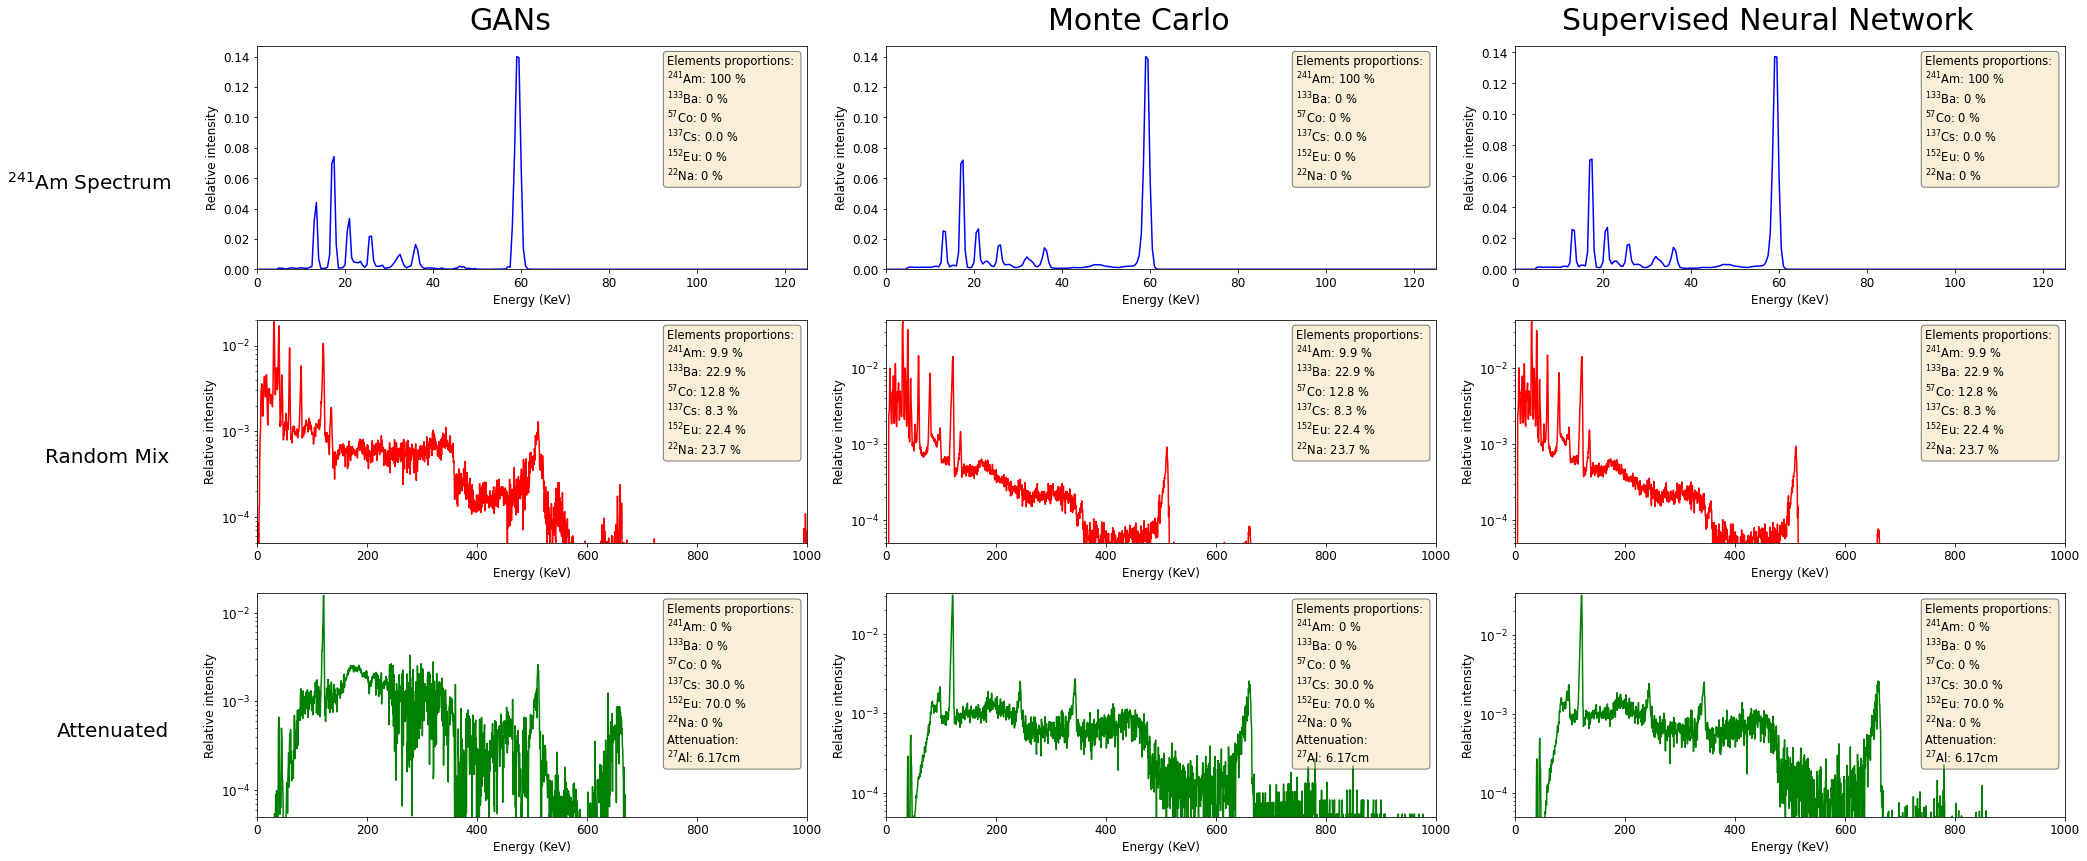

In [226]:
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy


cols = ["GANs", "Monte Carlo", "Supervised Neural Network"]
# rows = ["Am Specrum", "Random Mix", f"""30% of Cs,
# 70% of Eu
# behind
#     6.17cm of Al"""]
# rows = [""]*3
rows = ["$^{241}$Am Spectrum", "Random Mix", "Attenuated"]

fig, axes = plt.subplots(
    nrows=3, ncols=3, figsize=(30, 12),
    gridspec_kw=dict(widtth_ratios=[1., 1., 1.])
)
plt.setp(axes.flat, xlabel='Energy (KeV)', ylabel='Relative intensity')


pad = 5  # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.46, 1.05), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=30, ha='center', va='baseline')

for ax, row in zip(axes[:, 0], rows):
    if len(row) > 20:
        ax.annotate(row, xy=(-2, -1), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    fontsize=20, ha='right', va='baseline', rotation=0)
    else:
        ax.annotate(row, xy=(-2, 0.2), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    fontsize=20, ha='right', va='baseline', rotation=0)

for i, method in enumerate(ms):
    for j, simulation in enumerate(ss):
        axes[j][i].plot(
            np.linspace(0,1000,2000),
            results[method][simulation],
            color=colors[j],
        )
        # Limit
        axes[j][i].set_xlim([0, x_limits[j]])
        axes[j][i].set_ylim([y_limits[j], None])
        # Notes
        prepare_box(axes[j][i], proportions[j], box_positions[j])
        # Scale
        axes[j][i].set_yscale(scales[j])


fig.tight_layout()
# tight_layout doesn't take these labels into account. We'll need
# to make some room. These numbers are are manually tweaked.
# You could automatically calculate them, but it's a pain.
fig.subplots_adjust(left=0.15, top=0.95)
plt.savefig('results_no_noise.pdf', bbox_inches='tight')

# Real Am detection

In [227]:
load_am = DataLoader(varv.RAW_DATA_PATH+"fits/")
fits = load_am.load_fits(remove_na=False)
energies = proc.get_energy_dict(fits)

In [228]:
spectre, bins = np.histogram(
                energies["am"], range=(0, 6000), bins=12000)


In [229]:
am_real =  spectre/np.sum(spectre)

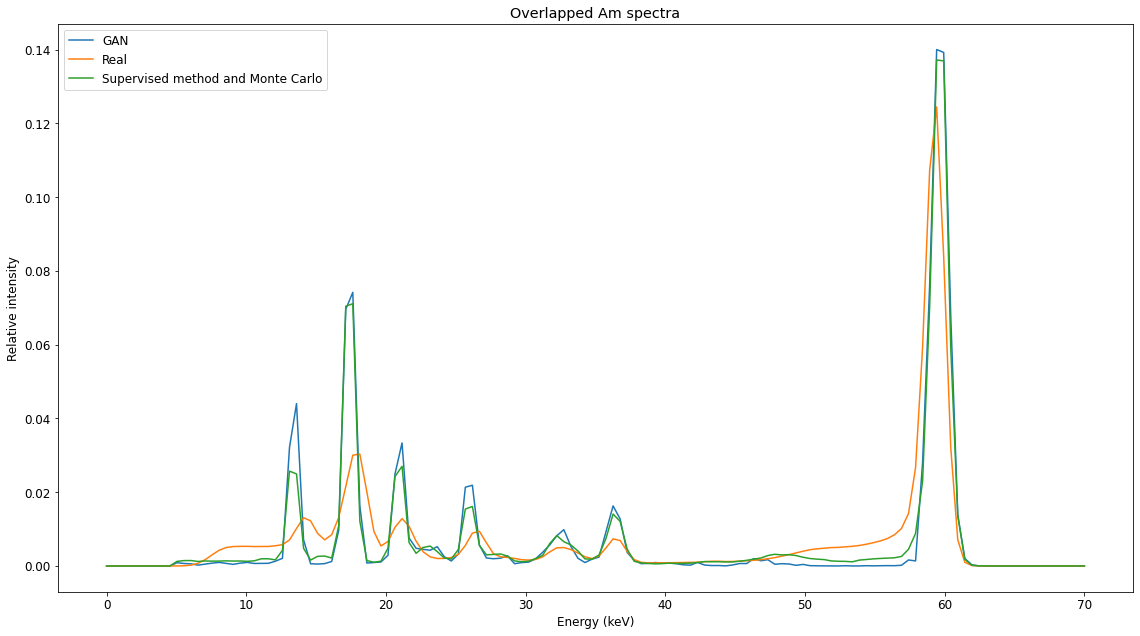

In [231]:
plt.figure(figsize=(16, 9))
plt.title("Overlapped Am spectra")


plt.plot(np.linspace(0,70,140), am_gan_norm[:140], label="GAN")
plt.plot(np.linspace(0,70,140), am_real[:140], label="Real")
plt.plot(np.linspace(0,70,140), jeff_am_clean[:140], label="Supervised method and Monte Carlo")

plt.ylabel("Relative intensity")
plt.xlabel("Energy (keV)")
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig('Americium Overlapped.pdf', bbox_inches='tight')

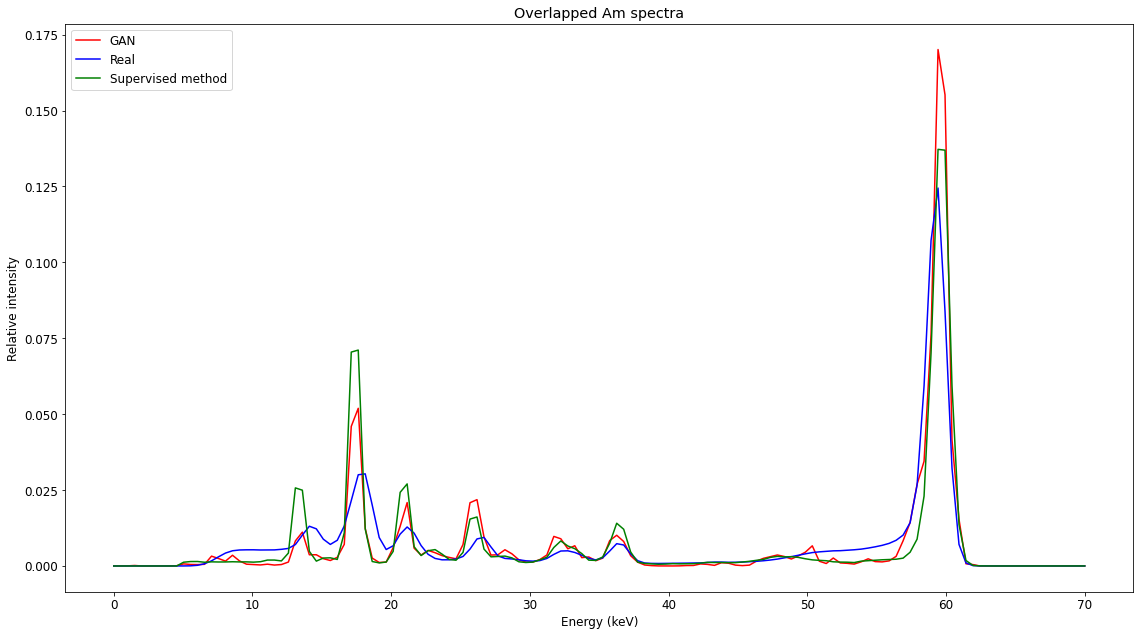

In [ ]:
plt.figure(figsize=(16, 9))
plt.title("Overlapped Am spectra")


plt.plot(np.linspace(0,70,140), am_gan_norm[:140], "-r", label="GAN")
plt.plot(np.linspace(0,70,140), am_real[:140], "-b", label="Real")
plt.plot(np.linspace(0,70,140), jeff_am_clean[:140], "-g", label="Supervised method")

plt.ylabel("Relative intensity")
plt.xlabel("Energy (keV)")
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig('Americium Overlapped.pdf', bbox_inches='tight')